# **Instacart Customer Behavior Analysis**

---

Instacart, the grocery ordering and delivery app Instacart is offering its transactional data on Kaggle wishing to predict their customers' reordering behavior. In this project, I will do EDA of the dataset to dig out a few insights of the customer behavior, and then conduct a t-test to figure out whether the frequency of ordering will affect customers' reorder rate.





The dataset is almost 300MB. I will mount the data into Google Drive and load them into the notebook.

In [0]:
# Mount data from google drive
from google.colab import drive 
drive.mount('/content/gdrive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/gdrive/


And then import every libraries needed here.


In [0]:

import pandas as pd
from scipy import stats
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import math
from sqlalchemy import create_engine
import warnings 
warnings.filterwarnings('ignore')


/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


Let's take a look at our datasets. The dataset is a relational set of files containing 3M orders from over 0.2M instacart users.
Dataset contains files: (aisles.csv, departments.csv, order_products_*.csv, orders.csv, products.csv)


In [0]:
# Read the csv files and created coresponding dataframes.
aisles_df=pd.read_csv('/content/gdrive/My Drive/Python_for_data_analysts/Final Capstone/dataset/aisles.csv')
departments_df=pd.read_csv('/content/gdrive/My Drive/Python_for_data_analysts/Final Capstone/dataset/departments.csv')
prior_df=pd.read_csv('/content/gdrive/My Drive/Python_for_data_analysts/Final Capstone/dataset/order_products__prior.csv')
train_df=pd.read_csv('/content/gdrive/My Drive/Python_for_data_analysts/Final Capstone/dataset/order_products__train.csv')
orders_df=pd.read_csv('/content/gdrive/My Drive/Python_for_data_analysts/Final Capstone/dataset/orders.csv')
products_df=pd.read_csv('/content/gdrive/My Drive/Python_for_data_analysts/Final Capstone/dataset/products.csv')


In [0]:
# Let's take a look at the prior, train and orders to see if there are any insights we can dig into.
#prior_df.head(10)
#train_df.head(10)
orders_df.head(10)
#prior_df.describe()
#train_df.describe()
#aisles_df.head()

,order_id,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order
0,2539329,1,prior,1,2,8,NaN
1,2398795,1,prior,2,3,7,15.0
2,473747,1,prior,3,3,12,21.0
3,2254736,1,prior,4,4,7,29.0
4,431534,1,prior,5,4,15,28.0
5,3367565,1,prior,6,2,7,19.0
6,550135,1,prior,7,1,9,20.0
7,3108588,1,prior,8,1,14,14.0
8,2295261,1,prior,9,1,16,0.0
9,2550362,1,prior,10,4,8,30.0


Use merge method to connect every table of the datasets. I choose order_products_train table as the main table connecting the other tables.

In [0]:
# merge/join prior, orders and other dataframes.
data=train_df.merge(orders_df, how= 'inner').merge(products_df, how='inner').merge(departments_df,how='inner').merge(aisles_df, how='inner')

In [0]:
# Let's take a look at our merged dataframe.  
data.head(10)

,order_id,product_id,add_to_cart_order,reordered,user_id,eval_set,order_number,order_dow,order_hour_of_day,days_since_prior_order,product_name,aisle_id,department_id,department,aisle
0,1,49302,1,1,112108,train,4,4,10,9.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
1,816049,49302,7,1,47901,train,14,4,6,16.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
2,1242203,49302,1,1,2993,train,15,0,7,7.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
3,1383349,49302,11,1,41425,train,4,3,8,14.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
4,1787378,49302,8,0,187205,train,5,4,14,30.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
5,2445303,49302,2,1,199120,train,49,3,20,7.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
6,2853065,49302,12,1,145852,train,7,1,19,15.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
7,3231517,49302,6,1,63189,train,42,2,13,7.0,Bulgarian Yogurt,120,16,dairy eggs,yogurt
8,98,43654,3,1,56463,train,41,3,8,14.0,Whole Milk Greek Blended Vanilla Bean Yogurt,120,16,dairy eggs,yogurt
9,13746,43654,9,0,158341,train,41,1,17,8.0,Whole Milk Greek Blended Vanilla Bean Yogurt,120,16,dairy eggs,yogurt


The data contains 1.38 million entries recording the products in every order. It also contains information about users, order status, aisles and departments. 

In [0]:
data.shap

(1384617, 15)

# Exploratory Analysis and Data Visualization





*   How many products do people purchase per order?



In [0]:
# What is the average number of products in each order?
order_max = data.pivot_table(index='order_id', values ='add_to_cart_order', aggfunc = 'max')
order_max.head()
order_max['add_to_cart_order'].mean()

10.552759338155157



*   When do people order?




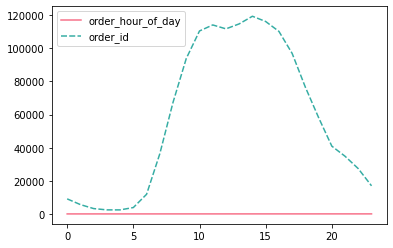

In [0]:
# When do people order at the hour of a day, and the day of a week?
data_day = data[['order_id', 'order_hour_of_day']].groupby(['order_hour_of_day']).agg(['count'])
data_day1=data_day.reset_index()
ax_day = sns.lineplot(data=data_day1, palette='husl' )
#ax_day = sns.countplot(x='order_hour_of_day', data = data, palette='husl')
plt.ylabel('orders')


0    324026
6    207279
1    205978
5    176910
2    160562
4    155481
3    154381
Name: order_dow, dtype: int64


Text(0, 0.5, 'orders')

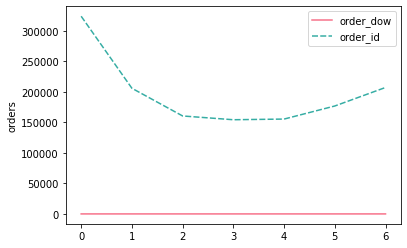

In [0]:
print(data['order_dow'].value_counts())
#ax_week = sns.countplot(x='order_dow',data=data, palette = 'CMRmap_r')
#data_dow = data.groupby('order_dow').count()
#data_dow.info()
#ax_week=sns.lineplot(x='order_dow', y='order_id', data=data_dow)

data_dow = data[['order_id','order_dow']].groupby(['order_dow']).agg(['count'])
data_dow1 = data_dow.reset_index()
data_dow1.head()
ax_dow = sns.lineplot(data=data_dow1,  palette = 'husl')
plt.ylabel('orders')

9am to 5pm and Sundays are clearly peaks of ordering time. People tend to make orders during weekends.



*   What do people order?




[Text(0, 0, 'Banana'),
 Text(0, 0, 'Bag of Organic Bananas'),
 Text(0, 0, 'Organic Strawberries'),
 Text(0, 0, 'Organic Baby Spinach'),
 Text(0, 0, 'Large Lemon'),
 Text(0, 0, 'Organic Avocado'),
 Text(0, 0, 'Organic Hass Avocado'),
 Text(0, 0, 'Strawberries'),
 Text(0, 0, 'Limes')]

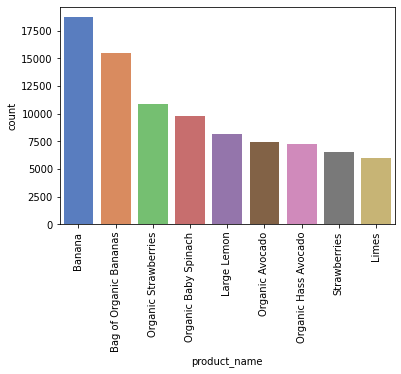

In [0]:
# what's the most popular items?
popular_products = data['product_name'].value_counts()

# create a bar chart of the popular products
ax = sns.countplot(x=data['product_name'], data=data, order=data.product_name.value_counts().iloc[:9].index, palette='muted')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


In the most popular ordered items chart, fruit is a clear winner. People tend to order organic fruits as half of the top orders are organic fruits. Banana is the more frequently ordered product.

*   When do people order again?

Text(0, 0.5, 'orders')

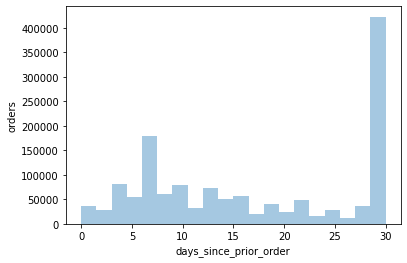

In [0]:
# - how long do people make an order after last orders?
ax_frequency = sns.distplot(data['days_since_prior_order'], bins=20, kde=False)
plt.ylabel('orders')

Looks like except for those who randomly pickup the app after one month, the most common order frequency is after one week.

*   How often do people repeat their previous orders?



In [0]:
# find out the reorder rate of purchase.
reorder = data.loc[(data['reordered']==1).values]
no_reorder = data.loc[(data['reordered']==0).values]
reorder_counts = reorder['reordered'].value_counts().tolist()[0]
noreorder_counts = no_reorder['reordered'].value_counts().tolist()[0]
print(noreorder_counts)
ratio = reorder_counts / (reorder_counts + noreorder_counts)
print(ratio)

data.groupby('reordered').size()
data['reordered'].value_counts(normalize = True)


555793
0.5985944127509629


1    0.598594
0    0.401406
Name: reordered, dtype: float64

The average reorder rate is aound 60%.



*   Customer behavior insights: what are the first items people put into their cart? And what are the last ones?



[Text(0, 0, 'Banana'),
 Text(0, 0, 'Bag of Organic Bananas'),
 Text(0, 0, 'Organic Whole Milk'),
 Text(0, 0, 'Organic Avocado'),
 Text(0, 0, 'Organic Strawberries'),
 Text(0, 0, 'Organic Baby Spinach'),
 Text(0, 0, 'Organic Hass Avocado'),
 Text(0, 0, 'Spring Water'),
 Text(0, 0, 'Strawberries')]

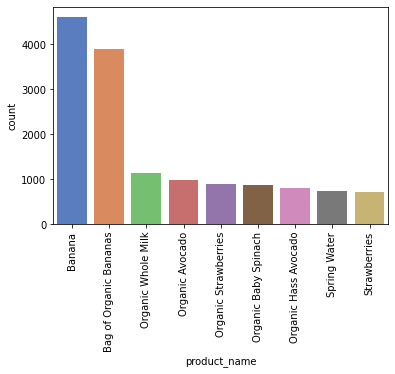

In [0]:
# What are the first items people put into their cart?
first_items = data.loc[data['add_to_cart_order'] ==1]
first_items.head()
ax = sns.countplot(x='product_name', data=first_items, order=first_items.product_name.value_counts().iloc[:9].index, palette='muted')
ax.set_xticklabels(ax.get_xticklabels(), rotation = 90)


[Text(0, 0, 'Banana'),
 Text(0, 0, 'Bag of Organic Bananas'),
 Text(0, 0, 'Organic Strawberries'),
 Text(0, 0, 'Organic Baby Spinach'),
 Text(0, 0, 'Large Lemon'),
 Text(0, 0, 'Organic Avocado'),
 Text(0, 0, 'Organic Hass Avocado'),
 Text(0, 0, 'Strawberries'),
 Text(0, 0, 'Limes')]

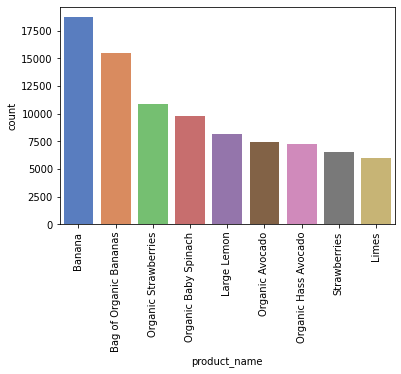

In [0]:
# What are the last items people put into their cart? 
last_item_df = pd.DataFrame(data, columns = ['order_id', 'product_name', 'add_to_cart_order'])
last_item_df.groupby('order_id').apply(lambda g:g[g['add_to_cart_order'] == g['add_to_cart_order'].max()])

ax2 = sns.countplot(x='product_name', data=last_item_df, order=last_item_df.product_name.value_counts().iloc[:9].index, palette='muted')
ax2.set_xticklabels(ax2.get_xticklabels(), rotation = 90)

Although the fruits, especially bananas,  are still popular when people open the app and choose products, organic whole milk and spring water are also first choices. The last calls are similar with the most popular ordered items though.


In conclusion, the order behavior of Instacart users are the followings:
People tend to use the app around 9am to 5pm, they make orders mostly on Sundays, and they tend to use the app again after one week, or one month. Each user will make around 10.5 orders, 60% are reordered items, and the most popular products are fruits -  bananas are a clearly winner. 



# Reorder rate and hypothesis
Reorder rate is an important index that can be used in predicting user behaviors and making product recommendations. Here, I want to conduct the analysis on our most loyal customers -their reorder rate higher than 86.7%. Then, I will test the hypothesis of whether the frequency of ordering have an impact on whether a user will reorder products.


To analyze the reorder rate correlated customer behavior, I want to make a pivot table out of our orginal data to focus on data on the user level, and add on the calculated reorder rate column.

In [0]:
# calculate the reorder rate per user using pivot table
data_users = data.pivot_table(index='user_id', values = ['reordered', 'order_id', 'days_since_prior_order'], aggfunc={'reordered':'sum','order_id':'count', 'days_since_prior_order':'mean'})
data_users['reorder_rate'] = data_users['reordered']/data_users['order_id']
data_users.reset_index()
data_users.info()


<class 'pandas.core.frame.DataFrame'>
Int64Index: 131209 entries, 1 to 206209
Data columns (total 4 columns):
 #   Column                  Non-Null Count   Dtype  
---  ------                  --------------   -----  
 0   days_since_prior_order  131209 non-null  float64
 1   order_id                131209 non-null  int64  
 2   reordered               131209 non-null  int64  
 3   reorder_rate            131209 non-null  float64
dtypes: float64(2), int64(2)
memory usage: 5.0 MB


Let's take a look at the distribution of reorder rate by using boxplot to show the mean, 25% and 75% level of reorder rate.


count    131209.000000
mean          0.602472
std           0.306763
min           0.000000
25%           0.375000
50%           0.631579
75%           0.866667
max           1.000000
Name: reorder_rate, dtype: float64

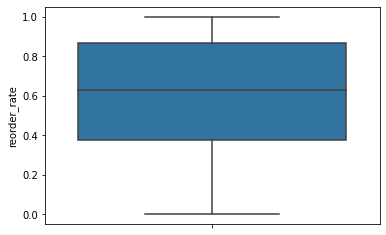

In [0]:
# let's take a look at the distribution of reorder rate by using boxplot 
sns.boxplot(y = 'reorder_rate', data = data_users)
data_users['reorder_rate'].describe()


Since the top 25% users have a reorder rate of 86.7%, we will consider these users as the top 'reorder users'. We want to find some behavior pattern of these particular persona.

In [0]:
data_users.isnull().sum()
top_users = data_users.loc[data_users['reorder_rate'] > 0.867]
print(top_users)

         days_since_prior_order  order_id  reordered  reorder_rate
user_id                                                           
1                          14.0        11         10      0.909091
7                           6.0         9          8      0.888889
9                          30.0        22         22      1.000000
24                          0.0         1          1      1.000000
29                         13.0        17         17      1.000000
...                         ...       ...        ...           ...
206154                     15.0        10          9      0.900000
206159                      9.0         1          1      1.000000
206162                     14.0         8          7      0.875000
206181                     30.0         9          9      1.000000
206203                     30.0        13         12      0.923077

[32727 rows x 4 columns]


we have 32727 users that have a reorder rate larger than 86.7%. 

Let's create a distplot to see the order frequency of our top reorder users.

Text(0, 0.5, 'users')

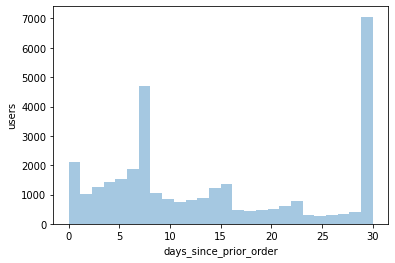

In [0]:
ax = sns.distplot(top_users['days_since_prior_order'], kde=False)
plt.ylabel('users')

Comparing with our total user pool, the top reorder users have a much clearer purchase pattern - 7 days order frenquency and 30 days order frequency have accounted for the vast majority of top users.

**Hypothesis testing**

---



To further understand the relationship between order frequency and reorder rate among our best reorder users, we want to test if there is a significant difference between the top users' reorder rate and their order frequency - 7 days (weekly) and 30 days (monthly).

> Null: There is no difference of reorder rate between top users with a shopping frequency of one week and top users with a shopping frequency with one month.


*   Ho: uw - um = 0
*   Ha: uw - um <>= 0


In [0]:
weekly_user = top_users.iloc[(top_users['days_since_prior_order'] == 7).values]
monthly_user = top_users.iloc[(top_users['days_since_prior_order']== 30).values]
weekly_user.info()
monthly_user.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3090 entries, 50 to 206082
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   days_since_prior_order  3090 non-null   float64
 1   order_id                3090 non-null   int64  
 2   reordered               3090 non-null   int64  
 3   reorder_rate            3090 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 120.7 KB
<class 'pandas.core.frame.DataFrame'>
Int64Index: 6738 entries, 9 to 206203
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   days_since_prior_order  6738 non-null   float64
 1   order_id                6738 non-null   int64  
 2   reordered               6738 non-null   int64  
 3   reorder_rate            6738 non-null   float64
dtypes: float64(2), int64(2)
memory usage: 263.2 KB


We have 3090 weekly users and 6738 monthly users. For a t-test, such dramatically different sample sizes with difference of variance might causing type II error. The solution is to randomly select 3000 users from the 6738 monthly users. 


In [0]:
monthly_user_3000 = monthly_user.sample(n=3000, random_state =1)
print(monthly_user_3000.head(500))
#monthly_user_3000.info()

         days_since_prior_order  order_id  reordered  reorder_rate
user_id                                                           
193966                     30.0         8          8      1.000000
69768                      30.0         5          5      1.000000
136405                     30.0         6          6      1.000000
73189                      30.0         3          3      1.000000
181436                     30.0        17         16      0.941176
...                         ...       ...        ...           ...
161893                     30.0        29         29      1.000000
36300                      30.0         6          6      1.000000
129654                     30.0         1          1      1.000000
72907                      30.0         1          1      1.000000
74191                      30.0         2          2      1.000000

[500 rows x 4 columns]


Let's take a look at their reorder rate distribution.

Text(0, 0.5, 'users')

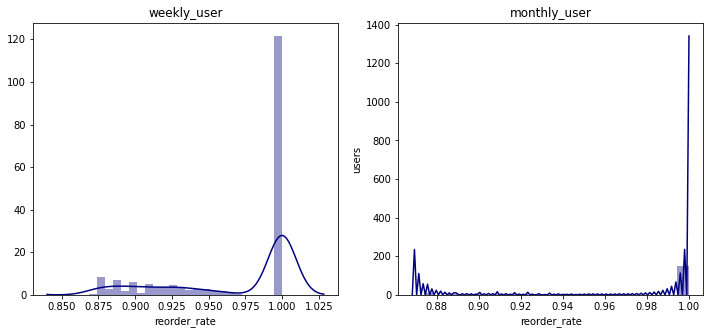

In [0]:
fig, ax = plt.subplots(1, 2, figsize = (12,5))
sns.distplot(weekly_user['reorder_rate'], bins=24, ax=ax[0], color = 'navy')
plt.ylabel('users')
ax[0].set_title('weekly_user')
sns.distplot(monthly_user_3000['reorder_rate'], bins=24, ax=ax[1], color = 'navy')
ax[1].set_title('monthly_user')
plt.ylabel('users')

It looks like from the distribution plot we can already see some difference between the weekly and monthly based reorder rate. The monthly_user distplot is much more left skewed indicating that there might be higher reorder_rate of monthly buyers than weekly's.

Let's run a test to test our hypothesis. The t-test will compare the means of these two samples and give a value that indicates how different these two means are. 


In [0]:
stats.ttest_ind(weekly_user['reorder_rate'], monthly_user_3000['reorder_rate'])

Ttest_indResult(statistic=-13.021130041877754, pvalue=2.997717229728271e-38)

There is a difference of -13 standard deviations between the two means. The p value is extremely small implying that this is a real difference. For sure reorder rate of even the most loyal users the weekly buyer and the monthly buyer still have significant difference. 


In [0]:
# Calculate the standard error and compute the confidence intervals
def get_95_ci(array1, array2):
  sample_1_n = array1.shape[0]
  sample_2_n = array2.shape[0]
  sample_1_mean = array1.mean()
  sample_2_mean = array2.mean()
  sample_1_var = array1.var()
  sample_2_var = array2.var()
  mean_difference = sample_1_mean - sample_2_mean
  std_err_difference = math.sqrt((sample_1_var/sample_1_n)+(sample_2_var/sample_2_n))
  margin_of_error = 1.96* std_err_difference
  ci_lower = mean_difference - margin_of_error
  ci_upper = mean_difference + margin_of_error
  return('The difference in means at the 95% confidence interval is between '+str(ci_lower)+' and '+str(ci_upper)+'.')
get_95_ci(weekly_user['reorder_rate'], monthly_user_3000['reorder_rate'])

'The difference in means at the 95% confidence interval is between -0.01575716571639796 and -0.011643567551340439.'

In [0]:
#Cohen'd function
def get_cohens_d(array1, array2):
  sample_1_n = array1.shape[0]
  sample_2_n = array2.shape[0]
  sample_1_mean = array1.mean()
  sample_2_mean = array2.mean()
  sample_1_var = array1.var()
  sample_2_var = array2.var()
  s_pooled = math.sqrt((sample_1_var + sample_2_var)/2)
  cohens = (sample_1_mean - sample_2_mean)/s_pooled

  return ("Cohen's d is " +str(cohens) +".")

print(get_cohens_d(weekly_user['reorder_rate'], monthly_user_3000['reorder_rate']))

Cohen's d is -0.33418784420713993.


The cohen's d at -.033 is indicating a relatively strong effect size. 

Text(0.5, 1.0, 'Reorder rate by weekly users vs montly users')

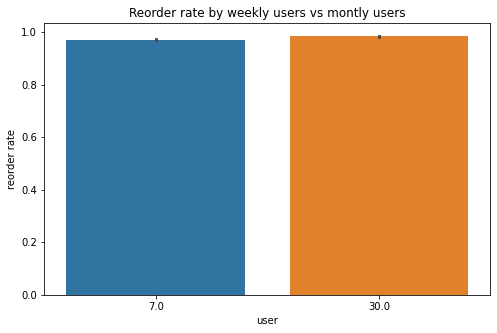

In [0]:
test_table = pd.concat([weekly_user, monthly_user_3000])

plt.figure(figsize=(8,5), )
sns.barplot(x='days_since_prior_order', y='reorder_rate', data=test_table)
plt.xlabel('user')
plt.ylabel('reorder rate')
plt.title('Reorder rate by weekly users vs montly users')

Based on the t-test data above, we can reject the null hypothesis that there is no difference of reorder rate between top users with a shopping frequency of one week and top users with a shopping frequency with one month. The monthly users reorder rate mean is 1.16% - 1.58% higher than the reorder rate mean of thoese weekly users with a relatively strong effect size.


# Conclusion

In conclusion, we will be able to reject the null hypothesis that order frequency will have no impact on user's reorder rate. Monthly users are clearly tend more to purchase the same products than weekly users. Based on the factor that a lot of people are paid monthly, it is possible that they will purchase the same bare necesitties every time when they are paid. A 1.16% to 1.58% higher reorder rate means that Instacart can better predict the monthly users and make better recommendations of product, even promote auto-reorder functions.